# Rt profile multicategorical versus uniform

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from cmdstanpy import CmdStanModel, cmdstan_path
import arviz as az
import nest_asyncio
import seaborn as sns
nest_asyncio.apply()

num_timepoints = 30 # number of days for incidence data
num_categories = 2

/Users/ioaros/opt/anaconda3/envs/testbranchpro2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameterize example branching process model with disagregated data

In [2]:
# Build the serial interval w_s
ws_mean = 15.3
ws_var = 9.3**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

# Simulate incidence data
initial_r = 0.1
serial_interval = disc_w

# contact_matrix = contact_matrix
contact_matrix = np.array([[12, 0.6], [6, 4.8]])
# contact_matrix = 1 * np.ones((2, 2))

transmissibility = [1, 0.5]
# transmissibility = [1.5, 1.5]

m = branchpro.MultiCatPoissonBranchProModel(
    initial_r, serial_interval, num_categories, contact_matrix, transmissibility)
new_rs = [0.088, 0.088]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = [50, 150] # initial number of cases
times = np.arange(num_timepoints)

desagg_cases = m.simulate(parameters, times, var_contacts=True)
agg_cases = np.sum(desagg_cases, axis=1)

print(desagg_cases)

[[ 50. 150.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   1.]
 [  2.   4.]
 [  3.   4.]
 [  4.   3.]
 [  5.   0.]
 [  1.   5.]
 [  4.   0.]
 [  2.   1.]
 [  4.   7.]
 [  4.   6.]
 [  1.   4.]
 [  5.   4.]
 [  4.   3.]
 [  3.   3.]
 [  7.   4.]
 [  0.   3.]
 [  9.   3.]
 [  5.   6.]
 [  4.   5.]
 [  5.   2.]
 [  5.   1.]
 [  6.   1.]
 [  2.   2.]
 [  1.   0.]
 [  2.   3.]
 [  1.   2.]]


In [3]:
eff_contact_matrix = np.matmul(contact_matrix, np.diag(transmissibility))

spec_radius = np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix)))

spec_radius * new_rs[-1]

1.0721897399620741

## Plot agreggated local incidence numbers

In [4]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=agg_cases,
        name='Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## R_t inference using STAN

In [5]:
# Same inference, but using the PoissonBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5
sigma = 1.5

# Correction for reproduction number per category
correc_i = np.multiply(np.sum(contact_matrix, axis=0), transmissibility)
correc_e = np.multiply(np.sum(m.exact_contact_matrix, axis=1), transmissibility)

In [6]:
# Transform our incidence data into pandas dataframes
multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

for _ in range(num_categories):
    multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
        desagg_cases[:, _]

multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': agg_cases
    }
)

L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, num_timepoints))

ground_truth = []
for j in range(num_categories):
    ground_truth.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': (new_rs[0]*correc_e[R_t_start:(start_times[1]+1), j]).tolist() + (new_rs[1]*correc_e[(start_times[1]+1):num_timepoints, j]).tolist()
    }))

In [7]:
poisson_model = CmdStanModel(stan_file=os.path.join(
        '../../stan_models/poisson_one.stan'))

poisson_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_27683/3414372969.py:7: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [8]:
fit = poisson_model.sample(
    data=poisson_data, seed=10, chains=3, iter_sampling=1000)

samples = az.from_cmdstanpy(fit)

az.summary(samples)

11:37:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |███████▋  | 00:02 Iterat


11:37:58 - cmdstanpy - INFO - CmdStan done processing.
11:37:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'poisson_one.stan', line 45, column 8 to column 28)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'poisson_one.stan', line 45, column 8 to column 28)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'poisson_one.stan', line 45, column 8 to column 28)
Consider re-running with show_console=True if the above output is unclear!


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   0.649  0.139   0.398    0.904      0.002    0.001    7229.0    2001.0   
R[1]   0.609  0.117   0.387    0.824      0.001    0.001    7049.0    2424.0   
R[2]   0.606  0.109   0.414    0.819      0.001    0.001    8050.0    2338.0   
R[3]   0.588  0.098   0.402    0.762      0.001    0.001    8592.0    2136.0   
R[4]   0.556  0.090   0.387    0.726      0.001    0.001    8542.0    2324.0   
R[5]   0.582  0.088   0.425    0.750      0.001    0.001    7206.0    2054.0   
R[6]   0.593  0.084   0.429    0.740      0.001    0.001    6804.0    2256.0   
R[7]   0.551  0.082   0.416    0.724      0.001    0.001    8053.0    2175.0   
R[8]   0.591  0.086   0.434    0.749      0.001    0.001    6651.0    2215.0   
R[9]   0.597  0.086   0.442    0.760      0.001    0.001    7185.0    2166.0   
R[10]  0.625  0.085   0.467    0.786      0.001    0.001    8051.0    2059.0   
R[11]  0.728  0.092   0.547    0.891      0.001    0.001    7519.0    2323.0   
R[12]  0.639  0.088   0.468    0.797      0.001    0.001    6093.0    2376.0   
R[13]  0.675  0.090   0.496    0.835      0.001    0.001    7118.0    2256.0   
R[14]  0.763  0.101   0.570    0.947      0.001    0.001    6932.0    2495.0   
R[15]  0.778  0.101   0.593    0.971      0.001    0.001    8383.0    2012.0   
R[16]  0.797  0.105   0.614    1.000      0.001    0.001    6857.0    2412.0   
R[17]  0.808  0.101   0.622    0.988      0.001    0.001    6491.0    1948.0   
R[18]  0.766  0.104   0.556    0.953      0.001    0.001    7466.0    2210.0   
R[19]  0.796  0.110   0.603    1.004      0.001    0.001    7560.0    1658.0   
R[20]  0.652  0.095   0.481    0.837      0.001    0.001    7417.0    2134.0   
R[21]  0.575  0.092   0.394    0.740      0.001    0.001    6948.0    2284.0   
R[22]  0.493  0.083   0.336    0.650      0.001    0.001    6760.0    1987.0   

       r_hat  
R[0]     1.0  
R[1]     1.0  
R[2]     1.0  
R[3]     1.0  
R[4]     1.0  
R[5]     1.0  
R[6]     1.0  
R[7]     1.0  
R[8]     1.0  
R[9]     1.0  
R[10]    1.0  
R[11]    1.0  
R[12]    1.0  
R[13]    1.0  
R[14]    1.0  
R[15]    1.0  
R[16]    1.0  
R[17]    1.0  
R[18]    1.0  
R[19]    1.0  
R[20]    1.0  
R[21]    1.0  
R[22]    1.0

In [9]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit.draws()[500:, :, 7:]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, 0, :],
    chain_samples[:, 1, :],
    chain_samples[:, 2, :]), axis=0)

thinning = max(1, int(n_sample * n_chains / 500))

pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0),
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0),
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0),
    'Central Probability': (L1+L2) * [0.95]
})

In [10]:
fig = ReproductionNumberPlot()

for j in range(num_categories):
    fig.add_ground_truth_rt(ground_truth[j], shape=[None, 'dash'][j])
    fig.figure.data[j]['name'] = 'True R<sup>({})</sup><sub>t</sub>' .format(j+1)
fig.add_interval_rt(pois_intervals, colour='deepskyblue', model_type='One group model')
fig.figure.data[2]['name'] = 'Estimated R<sub>t</sub> One-group model'

fig.figure['data'][-1]['showlegend'] = False
fig.update_labels(time_label='Time (days)', r_label='Reproduction number R<sub>t</sub>')

fig.figure.add_hline(
    y=1, line_dash='dot',
    annotation_text='R<sub>t</sub>=1', fillcolor='black',
    annotation_position='top right')

fig.figure.update_layout(
    width=900, 
    height=500,
    plot_bgcolor='white',
    font=dict(
            size=16),
    xaxis=dict(
        linecolor='black'),
    yaxis=dict(
        linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
)

fig.figure.write_image('images/Figure S2.pdf')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



## 1. Exact Contact data + Group-specific cases + Poisson Branching process with multiple categories

In [10]:
exact_multicat_model = CmdStanModel(stan_file=os.path.join(
        '../../stan_models/exact_multicat.stan'))

exact_multicat_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'n': num_categories,
    'C': np.array(m.exact_contact_matrix),
    'transm': transmissibility,
    'I': desagg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_94390/2203937616.py:67: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [11]:
fit = exact_multicat_model.sample(
    data=exact_multicat_data, seed=10, chains=3, iter_sampling=1000)

samples = az.from_cmdstanpy(fit)

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2300/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2801/6000)
Samp

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   0.109  0.025   0.067    0.158        0.0      0.0    6861.0    2092.0   
R[1]   0.094  0.021   0.056    0.136        0.0      0.0    6099.0    2309.0   
R[2]   0.088  0.018   0.057    0.124        0.0      0.0    5774.0    1792.0   
R[3]   0.088  0.018   0.057    0.122        0.0      0.0    6894.0    2060.0   
R[4]   0.070  0.013   0.045    0.095        0.0      0.0    6905.0    2204.0   
R[5]   0.077  0.014   0.050    0.101        0.0      0.0    5284.0    2034.0   
R[6]   0.079  0.013   0.056    0.105        0.0      0.0    5710.0    2295.0   
R[7]   0.079  0.013   0.055    0.103        0.0      0.0    6213.0    2270.0   
R[8]   0.079  0.012   0.058    0.102        0.0      0.0    8001.0    2211.0   
R[9]   0.078  0.012   0.056    0.102        0.0      0.0    5160.0    2010.0   
R[10]  0.079  0.012   0.057    0.102        0.0      0.0    5566.0    1923.0   
R[11]  0.083  0.012   0.061    0.105        0.0      0.0    5714.0    2440.0   
R[12]  0.072  0.012   0.048    0.095        0.0      0.0    5994.0    1769.0   
R[13]  0.066  0.013   0.044    0.090        0.0      0.0    6666.0    2242.0   
R[14]  0.066  0.012   0.044    0.090        0.0      0.0    5601.0    2209.0   
R[15]  0.061  0.012   0.041    0.083        0.0      0.0    4891.0    2296.0   
R[16]  0.072  0.013   0.048    0.096        0.0      0.0    6638.0    2231.0   
R[17]  0.072  0.013   0.048    0.096        0.0      0.0    6143.0    2126.0   
R[18]  0.075  0.013   0.051    0.101        0.0      0.0    5774.0    1989.0   
R[19]  0.084  0.014   0.060    0.112        0.0      0.0    6943.0    2113.0   
R[20]  0.089  0.014   0.065    0.116        0.0      0.0    5304.0    2099.0   
R[21]  0.096  0.015   0.068    0.123        0.0      0.0    6088.0    2156.0   
R[22]  0.110  0.016   0.079    0.140        0.0      0.0    7187.0    2206.0   

       r_hat  
R[0]     1.0  
R[1]     1.0  
R[2]     1.0  
R[3]     1.0  
R[4]     1.0  
R[5]     1.0  
R[6]     1.0  
R[7]     1.0  
R[8]     1.0  
R[9]     1.0  
R[10]    1.0  
R[11]    1.0  
R[12]    1.0  
R[13]    1.0  
R[14]    1.0  
R[15]    1.0  
R[16]    1.0  
R[17]    1.0  
R[18]    1.0  
R[19]    1.0  
R[20]    1.0  
R[21]    1.0  
R[22]    1.0

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

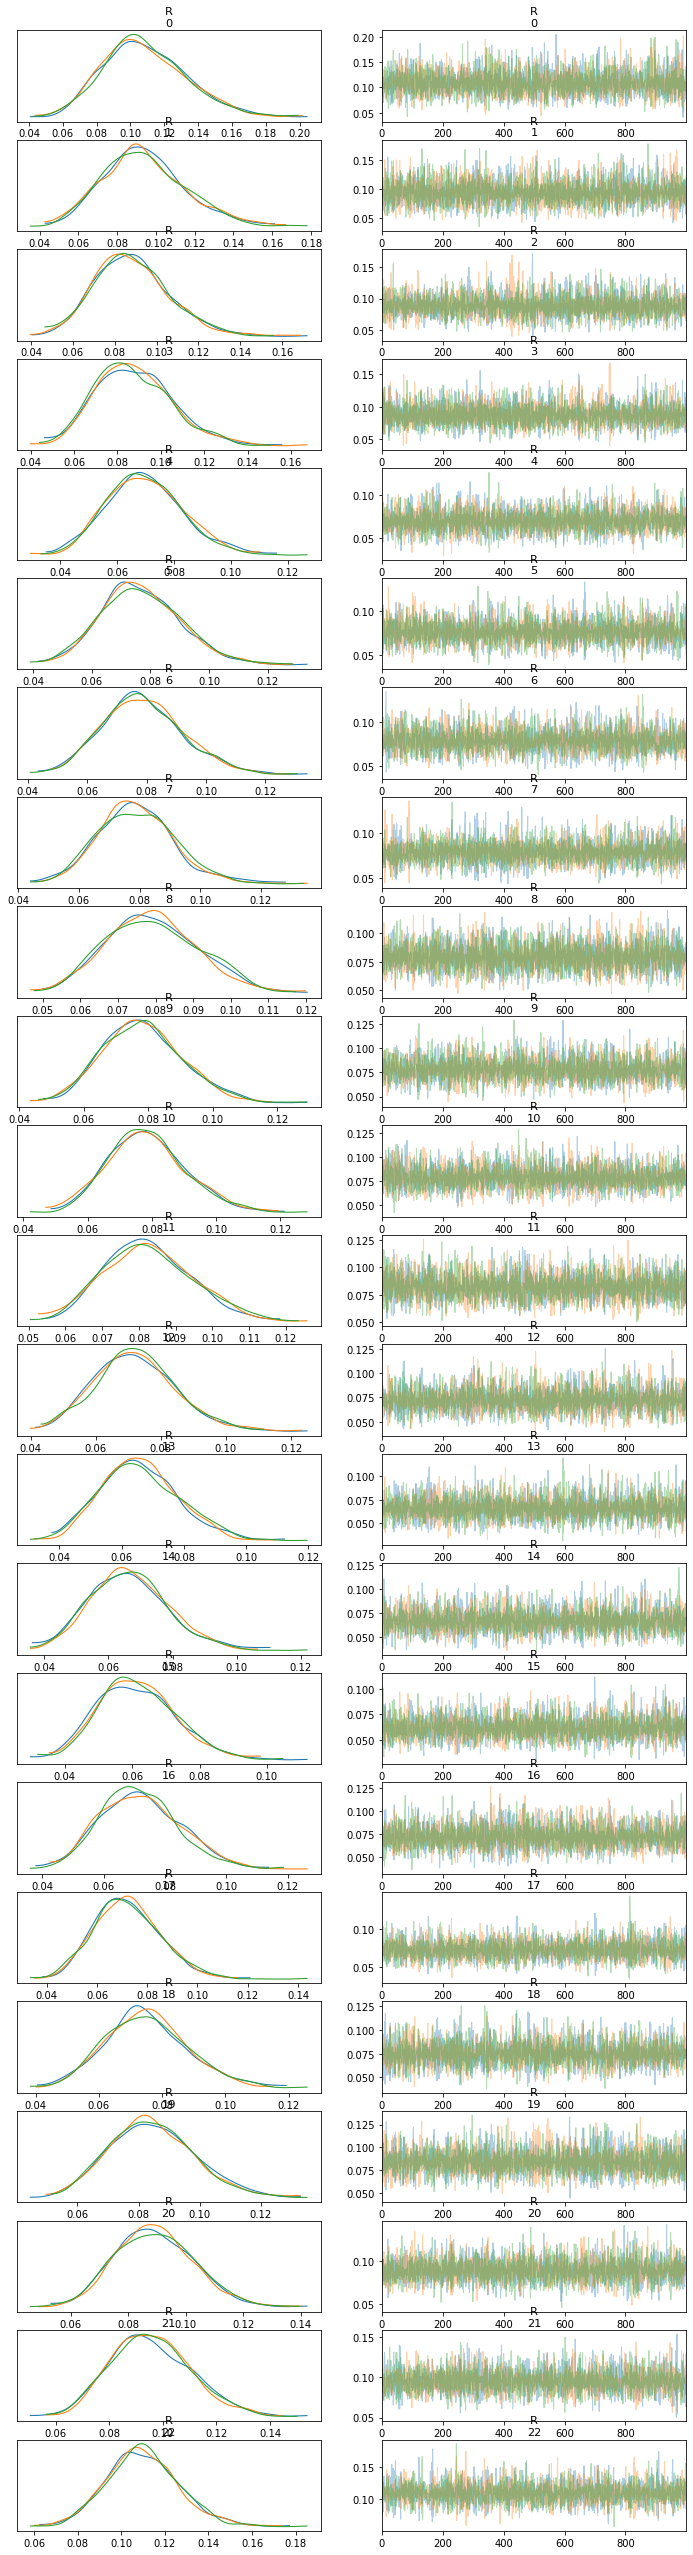

In [12]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [13]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit.draws()[500:, :, 7:]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, 0, :],
    chain_samples[:, 1, :],
    chain_samples[:, 2, :]), axis=0)

thinning = max(1, int(n_sample * n_chains / 500))
exact_multicat_intervals = []

for j in range(num_categories):
    exact_multicat_intervals.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'Mean': np.mean(extended_samples[::thinning, :] * correc_e[R_t_start:, j][None, :], axis=0),
        'Lower bound CI': np.quantile(extended_samples[::thinning, :] * correc_e[R_t_start:, j][None, :], 0.025, axis=0),
        'Upper bound CI': np.quantile(extended_samples[::thinning, :] * correc_e[R_t_start:, j][None, :], 0.975, axis=0),
        'Central Probability': (L1+L2) * [0.95]
    }))

## 2. Average Contact data + Group-specific cases + Poisson Branching process with multiple categories

In [14]:
approx_multicat_model = CmdStanModel(stan_file=os.path.join(
        '../../stan_models/approx_multicat.stan'))

approx_multicat_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'n': num_categories,
    'C': contact_matrix,
    'transm': transmissibility,
    'I': desagg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_94390/4283690943.py:67: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [15]:
fit = approx_multicat_model.sample(data=approx_multicat_data, seed=10, chains=3, iter_sampling=1000)

samples = az.from_cmdstanpy(fit)

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2300/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2801/6000)
Samp

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   0.107  0.025   0.064    0.156        0.0      0.0    6087.0    2007.0   
R[1]   0.089  0.020   0.055    0.129        0.0      0.0    6554.0    1977.0   
R[2]   0.082  0.017   0.051    0.113        0.0      0.0    6726.0    2041.0   
R[3]   0.076  0.016   0.048    0.107        0.0      0.0    7486.0    1977.0   
R[4]   0.065  0.013   0.042    0.089        0.0      0.0    6410.0    2297.0   
R[5]   0.075  0.014   0.050    0.101        0.0      0.0    5855.0    2290.0   
R[6]   0.080  0.013   0.055    0.104        0.0      0.0    4913.0    2019.0   
R[7]   0.086  0.014   0.060    0.112        0.0      0.0    5843.0    2083.0   
R[8]   0.088  0.014   0.063    0.114        0.0      0.0    5988.0    2316.0   
R[9]   0.086  0.013   0.062    0.111        0.0      0.0    6616.0    2089.0   
R[10]  0.092  0.013   0.067    0.117        0.0      0.0    5263.0    2289.0   
R[11]  0.089  0.013   0.065    0.115        0.0      0.0    5830.0    2106.0   
R[12]  0.073  0.012   0.049    0.096        0.0      0.0    5341.0    2170.0   
R[13]  0.061  0.011   0.039    0.081        0.0      0.0    5863.0    2157.0   
R[14]  0.059  0.011   0.039    0.078        0.0      0.0    5770.0    2636.0   
R[15]  0.055  0.011   0.036    0.075        0.0      0.0    6230.0    2614.0   
R[16]  0.066  0.012   0.045    0.087        0.0      0.0    6930.0    2152.0   
R[17]  0.065  0.012   0.044    0.088        0.0      0.0    6102.0    2072.0   
R[18]  0.073  0.012   0.050    0.095        0.0      0.0    5610.0    2334.0   
R[19]  0.085  0.014   0.060    0.113        0.0      0.0    5296.0    2137.0   
R[20]  0.092  0.014   0.066    0.116        0.0      0.0    5535.0    2226.0   
R[21]  0.098  0.016   0.070    0.127        0.0      0.0    7100.0    2309.0   
R[22]  0.113  0.017   0.081    0.144        0.0      0.0    6936.0    2122.0   

       r_hat  
R[0]     1.0  
R[1]     1.0  
R[2]     1.0  
R[3]     1.0  
R[4]     1.0  
R[5]     1.0  
R[6]     1.0  
R[7]     1.0  
R[8]     1.0  
R[9]     1.0  
R[10]    1.0  
R[11]    1.0  
R[12]    1.0  
R[13]    1.0  
R[14]    1.0  
R[15]    1.0  
R[16]    1.0  
R[17]    1.0  
R[18]    1.0  
R[19]    1.0  
R[20]    1.0  
R[21]    1.0  
R[22]    1.0

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

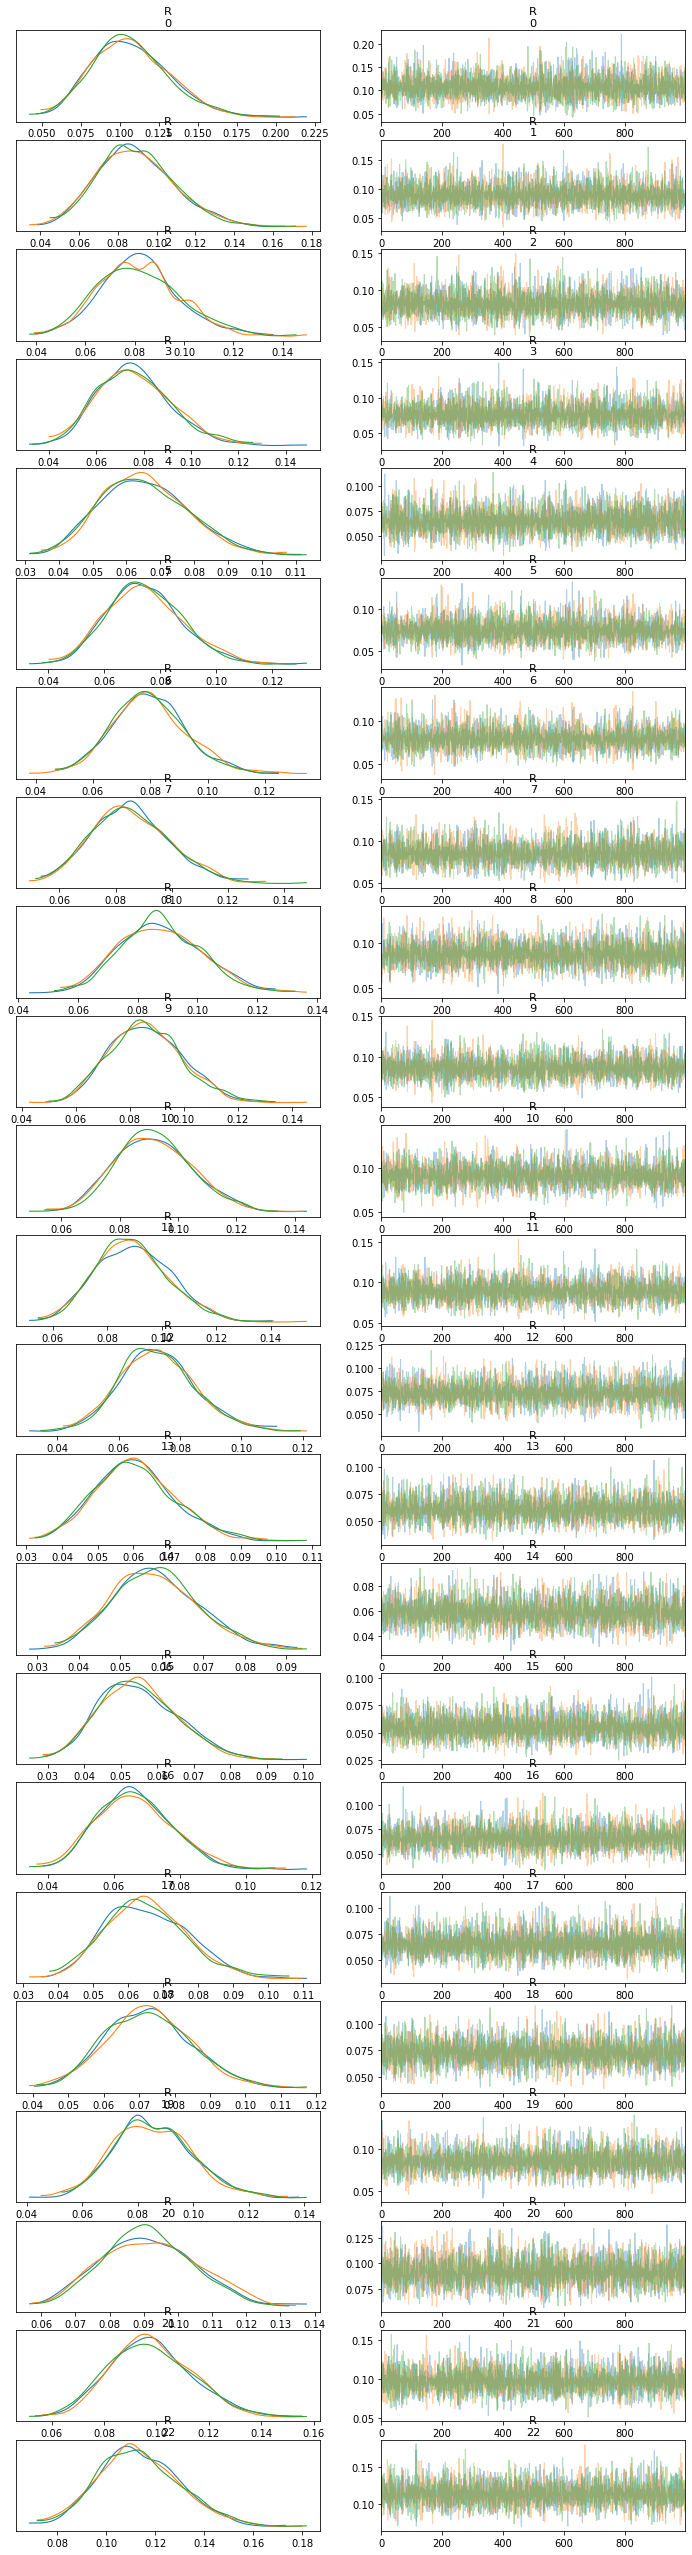

In [16]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [17]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit.draws()[500:, :, 7:]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, 0, :],
    chain_samples[:, 1, :],
    chain_samples[:, 2, :]), axis=0)

thinning = max(1, int(n_sample * n_chains / 500))
approx_multicat_intervals = []

for j in range(num_categories):
    approx_multicat_intervals.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'Mean': np.mean(correc_i[j] * extended_samples[::thinning, :], axis=0),
        'Lower bound CI': np.quantile(correc_i[j] * extended_samples[::thinning, :], 0.025, axis=0),
        'Upper bound CI': np.quantile(correc_i[j] * extended_samples[::thinning, :], 0.975, axis=0),
        'Central Probability': (L1+L2) * [0.95]
    }))

## 3. Exact Contact data + Total cases + Poisson Branching process with multiple categories

In [18]:
agg_multicat_model = CmdStanModel(stan_file=os.path.join(
        '../../stan_models/agg_multicat.stan'))

agg_multicat_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'n': num_categories,
    'C': contact_matrix,
    'transm': transmissibility,
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_94390/1251656915.py:73: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [19]:
fit = agg_multicat_model.sample(data=agg_multicat_data, seed=10, chains=3, iter_sampling=1000)

samples = az.from_cmdstanpy(fit)

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_1wcrya5i/model_pe5ykqxp.stan', line 46, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_1wcrya5i/model_pe5ykqxp.stan', line 51, column 12: A
    control flow statement depends on parameter(s): p.
Warning in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_1wcrya5i/model_pe5ykqxp.stan', line 21, column 24: A
    control flow statement inside function effective_no_infectives depends on
    argument t. At
    '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_1wcrya5i/model_pe5ykqxp.stan',
    line 54, column 33 to column 34, the value of t depends on parameter(s):
    p.
Warn

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
R[0]      0.238  0.058   0.130    0.344      0.001    0.001    2893.0   
R[1]      0.199  0.046   0.117    0.284      0.001    0.001    2575.0   
R[2]      0.185  0.040   0.113    0.258      0.001    0.001    2535.0   
R[3]      0.169  0.034   0.109    0.230      0.001    0.000    2555.0   
R[4]      0.145  0.031   0.090    0.204      0.001    0.000    2497.0   
...         ...    ...     ...      ...        ...      ...       ...   
p[27, 1]  0.505  0.292   0.038    0.970      0.004    0.003    4134.0   
p[28, 0]  0.491  0.289   0.030    0.961      0.005    0.004    2888.0   
p[28, 1]  0.509  0.289   0.039    0.970      0.005    0.004    2888.0   
p[29, 0]  0.502  0.290   0.054    0.989      0.005    0.004    3505.0   
p[29, 1]  0.498  0.290   0.011    0.946      0.005    0.003    3505.0   

          ess_tail  r_hat  
R[0]        1834.0    1.0  
R[1]        1650.0    1.0  
R[2]        1866.0    1.0  
R[3]        2107.0    1.0  
R[4]        1642.0    1.0  
...            ...    ...  
p[27, 1]    1901.0    1.0  
p[28, 0]    1980.0    1.0  
p[28, 1]    1980.0    1.0  
p[29, 0]    1591.0    1.0  
p[29, 1]    1591.0    1.0  

[83 rows x 9 columns]

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

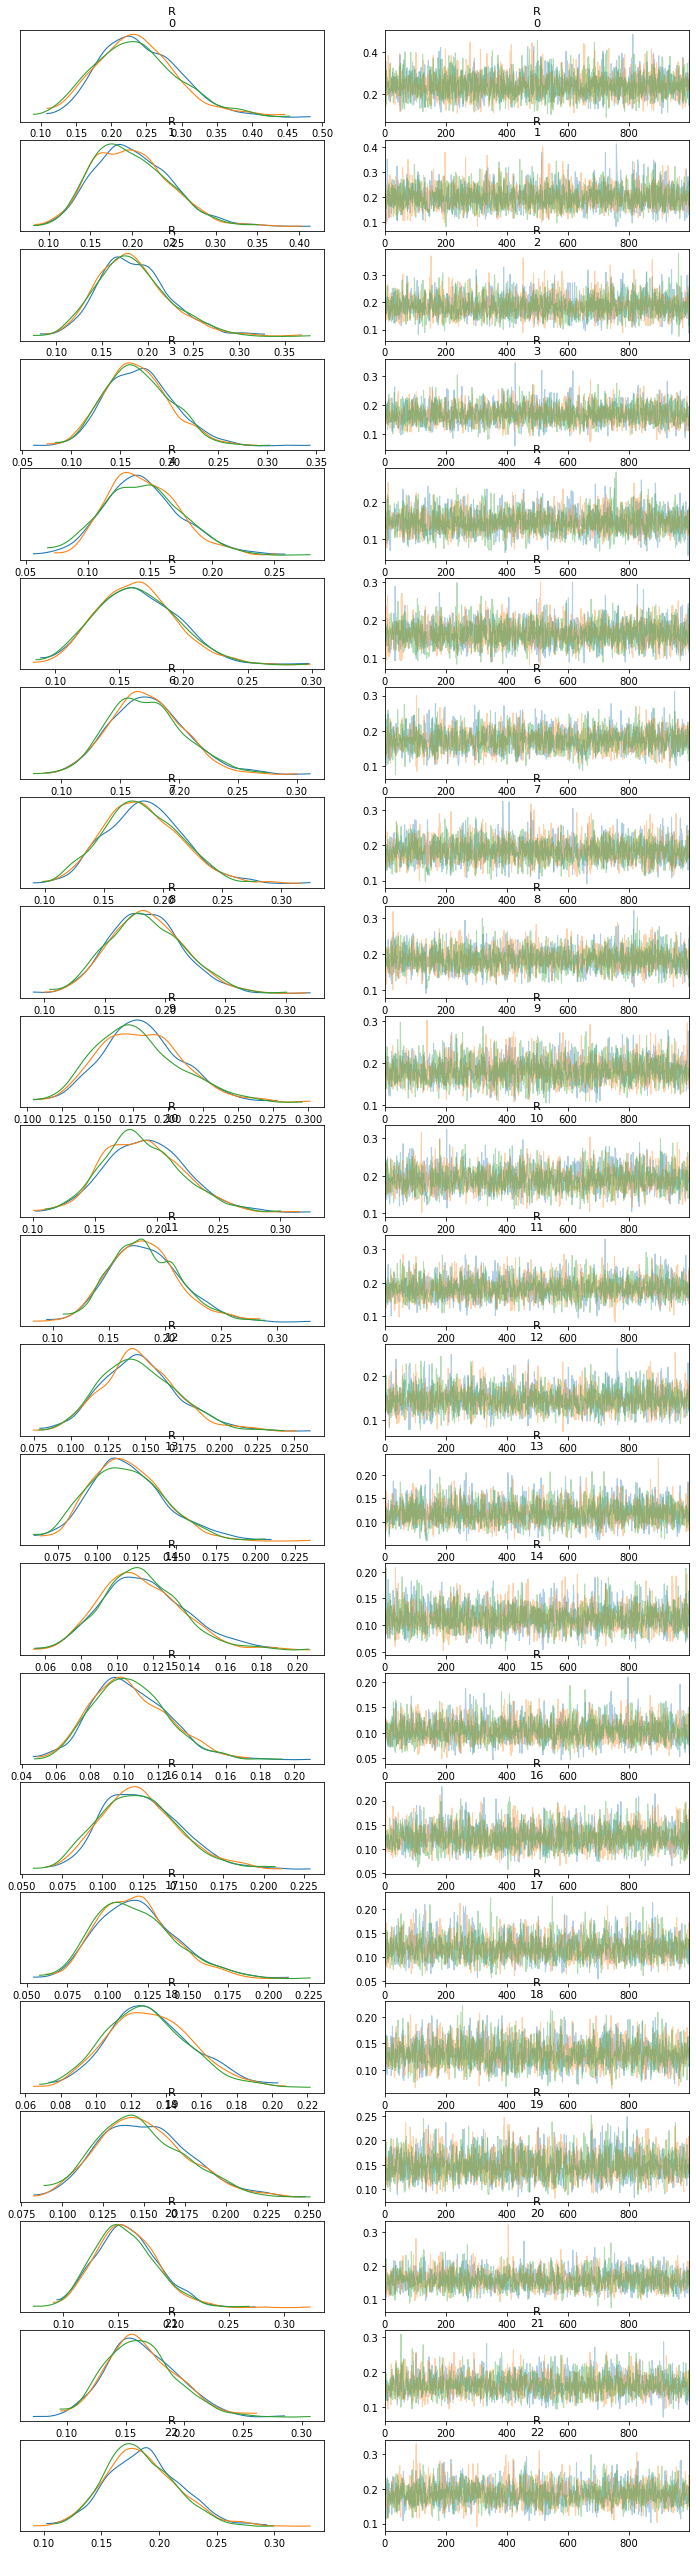

In [20]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

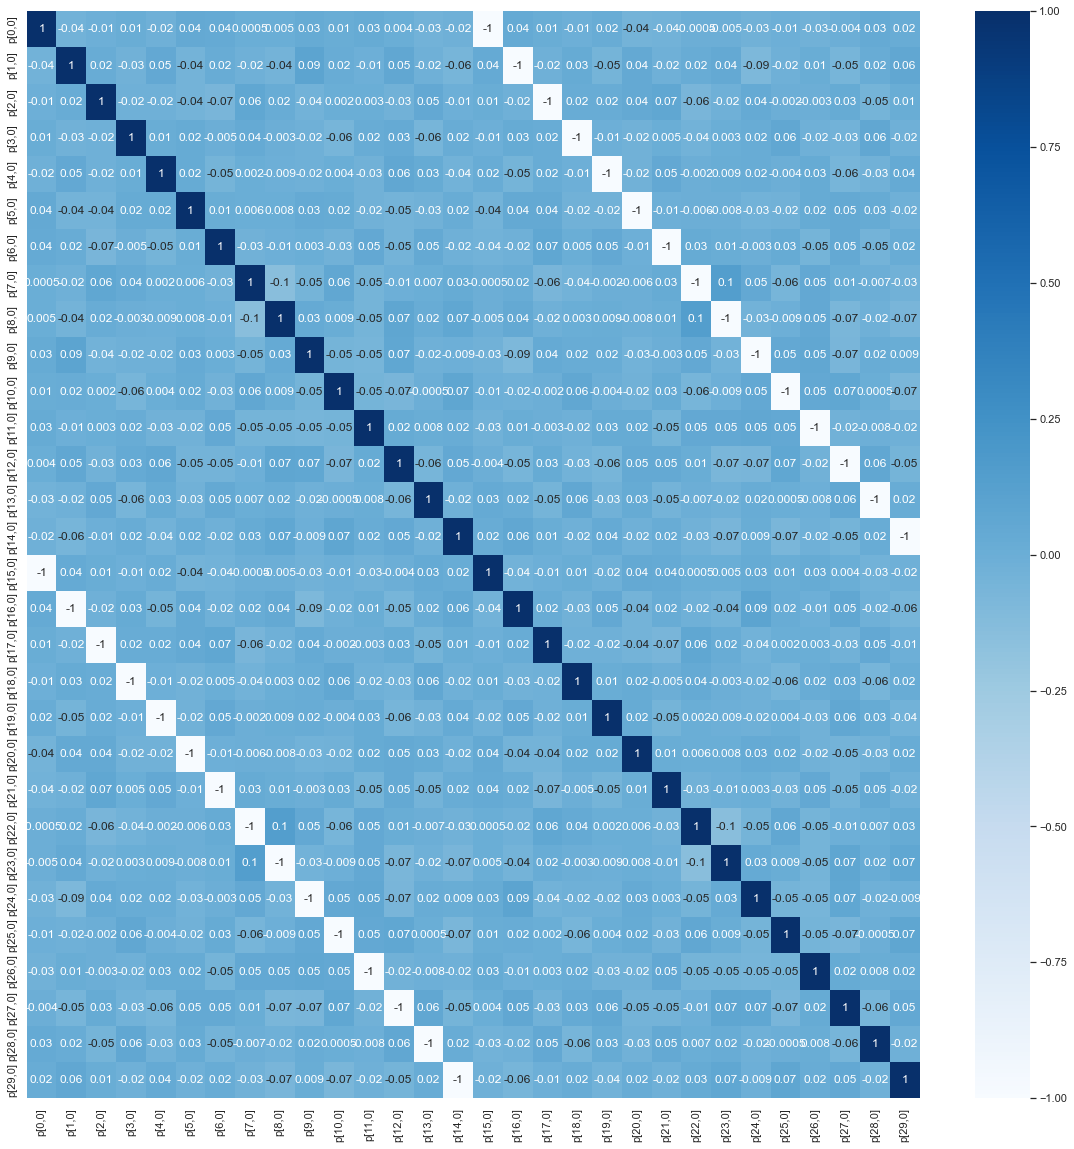

In [21]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
p_chain_samples = fit.draws()[500:, :, (num_timepoints - R_t_start +7)::num_categories]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = p_chain_samples.shape

extended_p_samples = np.concatenate((
    p_chain_samples[:, 0, :],
    p_chain_samples[:, 1, :],
    p_chain_samples[:, 2, :]), axis=0)

df = pd.DataFrame(
    np.transpose(extended_p_samples),
    columns=[
        'p[{},0]'.format(_)
        for _ in range(num_timepoints)])

plt.figure(figsize=(20,20))
sns.set_theme(style="white")
corr = df.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

In [22]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[500:, :, 7:(num_timepoints - R_t_start +7)]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, 0, :],
    chain_samples[:, 1, :],
    chain_samples[:, 2, :]), axis=0)

thinning = max(1, int(n_sample * n_chains / 500))
agg_multicat_intervals = []

for j in range(num_categories):
    agg_multicat_intervals.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'Mean': np.mean(correc_i[j] * extended_samples[::thinning, :], axis=0),
        'Lower bound CI': np.quantile(correc_i[j] * extended_samples[::thinning, :], 0.025, axis=0),
        'Upper bound CI': np.quantile(correc_i[j] * extended_samples[::thinning, :], 0.975, axis=0),
        'Central Probability': (L1+L2) * [0.95]
    }))

## 4. No Contact data + Total cases + Poisson Branching process

In [23]:
poisson_model = CmdStanModel(stan_file=os.path.join(
        '../../stan_models/poisson_one.stan'))

poisson_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_94390/1887272557.py:54: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [24]:
fit = poisson_model.sample(
    data=poisson_data, seed=10, chains=3, iter_sampling=1000)

samples = az.from_cmdstanpy(fit)

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000512 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.12 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_3__gswa5/model_hwu4itiu.stan', line 46, column 8 to column 28)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 0.000202 se

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   0.562  0.128   0.322    0.785      0.002    0.001    7099.0    2207.0   
R[1]   0.470  0.101   0.298    0.669      0.001    0.001    8046.0    1870.0   
R[2]   0.440  0.085   0.280    0.589      0.001    0.001    7326.0    2068.0   
R[3]   0.410  0.080   0.265    0.554      0.001    0.001    6942.0    2276.0   
R[4]   0.356  0.073   0.224    0.499      0.001    0.001    6623.0    2056.0   
R[5]   0.411  0.072   0.281    0.544      0.001    0.001    7576.0    2292.0   
R[6]   0.444  0.075   0.307    0.585      0.001    0.001    7062.0    2299.0   
R[7]   0.482  0.079   0.340    0.629      0.001    0.001    9269.0    2354.0   
R[8]   0.501  0.080   0.352    0.643      0.001    0.001    7256.0    2076.0   
R[9]   0.503  0.077   0.364    0.651      0.001    0.001    6884.0    2101.0   
R[10]  0.544  0.082   0.397    0.704      0.001    0.001    6478.0    2231.0   
R[11]  0.542  0.083   0.399    0.705      0.001    0.001    6471.0    2351.0   
R[12]  0.452  0.078   0.314    0.601      0.001    0.001    8433.0    2156.0   
R[13]  0.384  0.070   0.268    0.521      0.001    0.001    6545.0    2086.0   
R[14]  0.382  0.073   0.246    0.516      0.001    0.001    7864.0    2422.0   
R[15]  0.365  0.072   0.243    0.503      0.001    0.001    8209.0    2266.0   
R[16]  0.448  0.081   0.297    0.601      0.001    0.001    6186.0    1801.0   
R[17]  0.450  0.077   0.311    0.601      0.001    0.001    6590.0    2350.0   
R[18]  0.516  0.090   0.348    0.684      0.001    0.001    7148.0    2097.0   
R[19]  0.615  0.098   0.422    0.788      0.001    0.001    5759.0    2332.0   
R[20]  0.674  0.105   0.474    0.862      0.001    0.001    6316.0    2245.0   
R[21]  0.738  0.112   0.531    0.945      0.001    0.001    6772.0    2043.0   
R[22]  0.877  0.126   0.641    1.106      0.001    0.001    8472.0    2027.0   

       r_hat  
R[0]    1.00  
R[1]    1.01  
R[2]    1.00  
R[3]    1.00  
R[4]    1.00  
R[5]    1.01  
R[6]    1.00  
R[7]    1.00  
R[8]    1.00  
R[9]    1.00  
R[10]   1.00  
R[11]   1.00  
R[12]   1.00  
R[13]   1.00  
R[14]   1.00  
R[15]   1.00  
R[16]   1.00  
R[17]   1.00  
R[18]   1.00  
R[19]   1.00  
R[20]   1.00  
R[21]   1.00  
R[22]   1.00

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

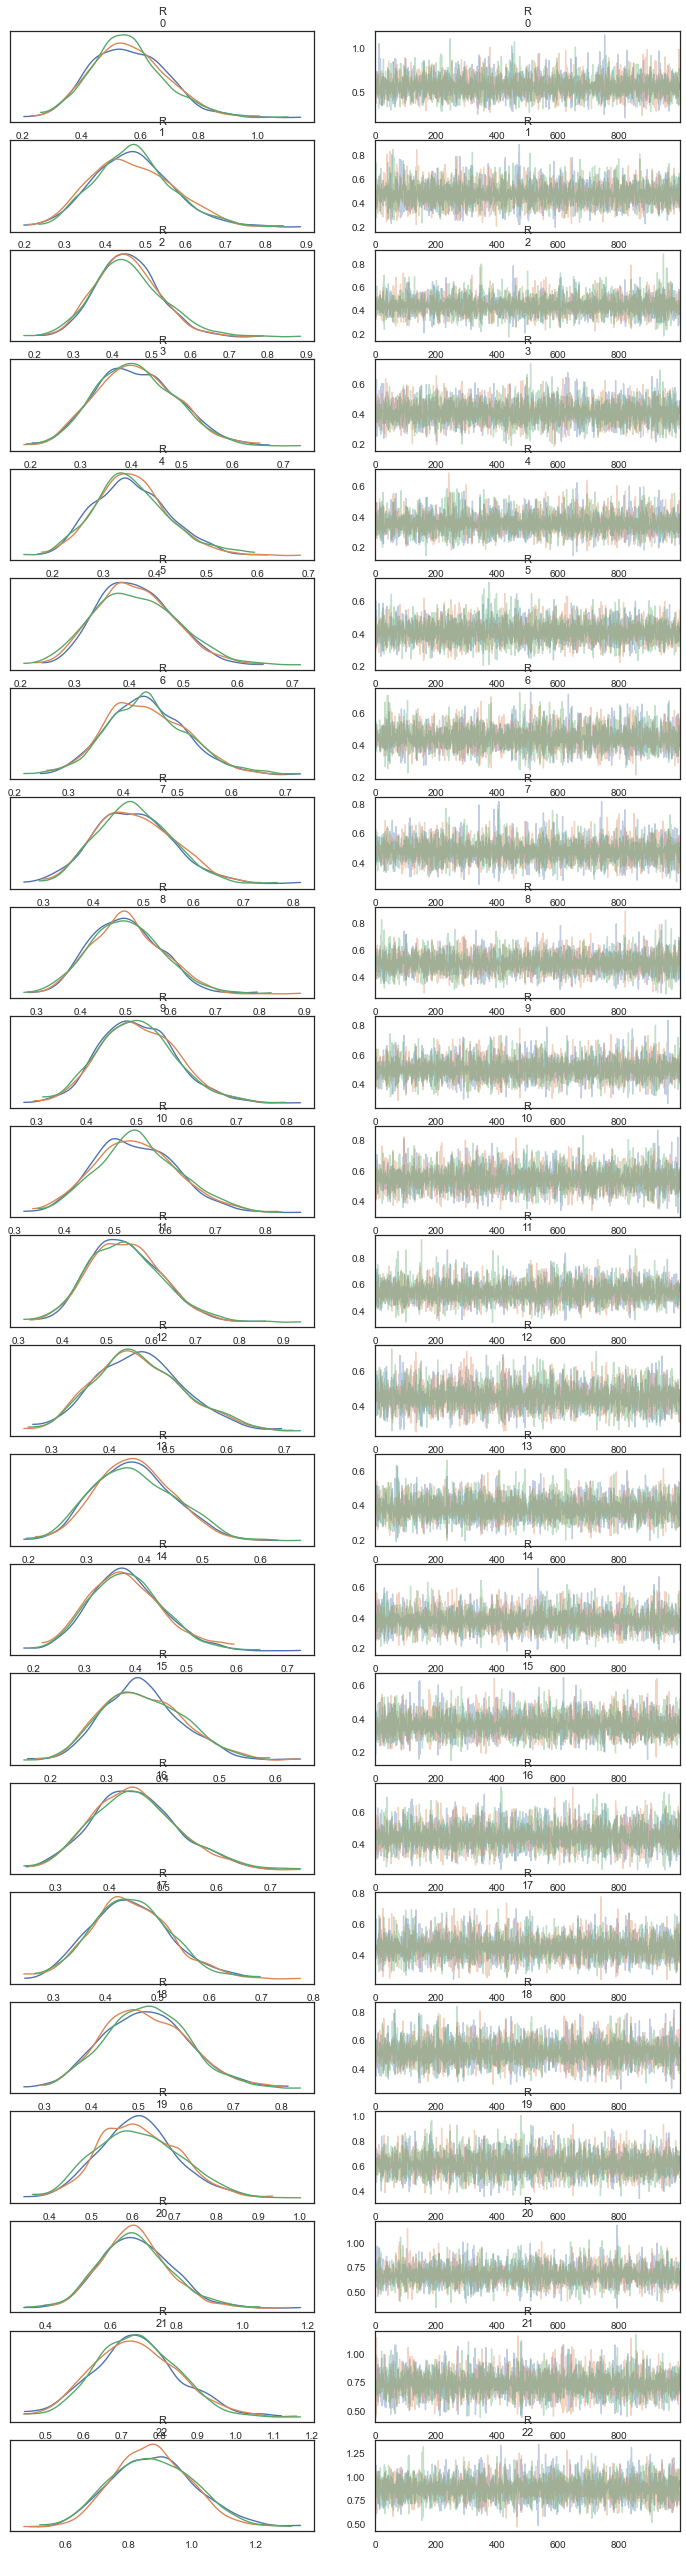

In [25]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [26]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit.draws()[500:, :, 7:]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, 0, :],
    chain_samples[:, 1, :],
    chain_samples[:, 2, :]), axis=0)

thinning = max(1, int(n_sample * n_chains / 500))

pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0),
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0),
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0),
    'Central Probability': (L1+L2) * [0.95]
})